In [1]:
from ROOT import TLorentzVector,TGenPhaseSpace,gRandom,TF1
from ROOT import TCanvas,TH1F,TH2F,kRed,kBlue,gStyle,TLegend,TPaveLabel

from root_numpy import array2root,fill_hist
import numpy as np
from math import sqrt
from random import gauss, choice
from matplotlib import pyplot as plt
plt.style.use('dark_background')

Welcome to JupyROOT 6.14/04


In [3]:
# this defines a function to calculate the invariant mass
# and delat_phi(p1,p2)
# from the structured arrays
P1 = TLorentzVector()
P2 = TLorentzVector()

def getMdphiHelp(pt1,eta1,phi1,E1,pt2,eta2,phi2,E2):
    P1.SetPtEtaPhiE(pt1,eta1,phi1,E1)
    P2.SetPtEtaPhiE(pt2,eta2,phi2,E2)
    # due to the smearing the (p1+p2)^2 may become negative
    # we set neg masses to zero
    return max((P1+P2).M(),0),P1.Angle(P2.Vect())
uGetMdphi = np.frompyfunc(getMdphiHelp, 8, 2) # make it an universial function, i.e. acts on arrays
def getMdphi(t):
    return uGetMdphi(t['Pt1'],t['Eta1'],t['Phi1'],t['E1'],t['Pt2'],t['Eta2'],t['Phi2'],t['E2'])

### We consider a heavy new particle of 750 GeV that decays into 2 massless particles:

$P\rightarrow p_1+p_2$

Our heavy particle has some arbitrary initial momentum $p_z$ in the lab frame: 

$\exp(-\frac{1}{\alpha}p_z), \; \alpha=500\;\mbox{GeV and } p_z>100\,\mbox{GeV.}$

* The first cell is a little MC generator for this kind of events. 
* The generated events are written into a *ROOT* file: `toy.root` .
 - `numpy_root` (http://scikit-hep.org/root_numpy/start.html)
 - numpy_root uses structured numpy arrays. This allows to define a name and a type.
* The Branch names are
 - **Pt1, Phi1, Eta1, E1, Pt2, Phi2, Eta2, E2**
 - **pz** the initial z momentum of the heavy particle
 - the derivate quantities: **mass**$=(p_1+p_2)^2$, **dphi**=$\angle(\vec{p_1},\vec{p_2})$|
 - **weight** 1 for background and 0.1 for signal
 - **label** $\in \{1,0\}$ for signal/background
 - A cut **E1, E2 $>$ 300 GeV** is applied
* Some experimental realism is introduced by smearing energy and momentum
 - Energy resolution `eres` is assumed to be 10%
 - momentum resolution `pres` is assumed to be 4%
* In addition, we create a kind of combinatorical background by remixing such events

In [4]:
#----- a tiny MC generator -------------------
#
# We create multiple event: a heavy new particle decays into 2 massless particles: P->p1+p2
# Our heavy particle has some arbitrary initial momentum pz in the lab frame: 
# exp(-x/500), x>100
#
gRandom.SetSeed(0)

nev  = 50000 # number of events to generate

eres = 0.1  # energy resolution 10%
pres = 0.04 # momentum resolution

# branch names and types for the root tree we will write
dataTypes=[('Pt1',   'f4'), 
           ('Eta1',  'f4'), 
           ('Phi1',  'f4'), 
           ('E1',    'f4'), 
           ('Pt2',   'f4'), 
           ('Eta2',  'f4'), 
           ('Phi2',  'f4'), 
           ('E2',    'f4'), 
#redundant           
           ('Px1',   'f4'), 
           ('Py1',   'f4'), 
           ('Pz1',   'f4'), 
           ('Px2',   'f4'), 
           ('Py2',   'f4'), 
           ('Pz2',   'f4'), 
#non-measured         
           ('pz',    'f4'),
           ('mass',  'f4'),
           ('dphi',  'f4'),
           ('weight','f4'), 
           ('label', 'i4')]
# empty arrays for signal and background
toy_s=np.empty(nev,dtype=dataTypes)
toy_b=np.empty(nev,dtype=dataTypes)

# the masses of our particles 
mass   = 750
masses = np.array([0.,0.])

# we use a ROOT 4-vector 
P      = TLorentzVector()
# this gives as the proper kinematic for a 2-body decay
decay  = TGenPhaseSpace()  # P->p1+p2 
# exponential falling pz of the heavy particle, with pz>100
fp     = TF1("f","exp(-x/500)",50,6500)
#
def makeToys(toy,w,l): 
    i=0
    while i<nev:
        # random pz with random +-direction
        pz = choice([1, -1])*fp.GetRandom()
        E  = sqrt(pz*pz+mass*mass)
        P.SetPxPyPzE(0,0,pz,E)
        # print P.M(),P.Pz()
        decay.SetDecay(P,2,masses)
        if not decay.Generate(): continue
        p1 = decay.GetDecay(0)
        p2 = decay.GetDecay(1)

        # experimental smearing and selection
        # this may even give totally "mis-reconstructed" negative mass
        #eres=0.000001
        E1=p1.E()*gauss(1,eres)
        # we select only high energetic particles
        if E1<300: continue
        E2=p2.E()*gauss(1,eres)
        if E2<300: continue
        p1.SetE(E1)
        p2.SetE(E2)
        p1.SetPx(p1.Px()*gauss(1,pres))
        p2.SetPx(p2.Px()*gauss(1,pres))
        p1.SetPy(p1.Py()*gauss(1,pres))
        p2.SetPy(p2.Py()*gauss(1,pres))
        p1.SetPz(p1.Pz()*gauss(1,pres))
        p2.SetPz(p2.Pz()*gauss(1,pres))
       
        # copy into predined structured array - except the calculated quantities mass and dphi which are left 0
        toy[i]=(p1.Pt(),p1.Eta(),p1.Phi(),p1.E(),p2.Pt(),p2.Eta(),p2.Phi(),p2.E(),p1.Px(),p1.Py(),p1.Pz(),p2.Px(),p2.Py(),p2.Pz(),pz,0,0,w,l)
        i+=1
# fill signal array and write it to a ROOT file
makeToys(toy_s,0.1,1)
# fill calculated columns: mass and dphi columns 
toy_s['mass'],toy_s['dphi']=getMdphi(toy_s)


# writing the array to a new root file, branch names follow dataTypes
array2root(toy_s,'toy.root', treename='tree', mode='recreate')

# a wicked (see below) background. 
# We create events as before but destroy the correlations by mixing
# fill backgrd array and reshuffle
makeToys(toy_b,1.0,0)
for nam in toy_b.dtype.names:
    np.random.shuffle(toy_b[nam])
# fill calculated columns: mass and dphi columns 
toy_b['mass'],toy_b['dphi']=getMdphi(toy_b)

#adding to exiting file
array2root(toy_b,'toy.root', treename='tree', mode='update')

### 1d distributions of signal and background

* By construction all 1d histograms of the meassured quantities $p=(p_T,\phi,\eta,E)$ are identical
 - Weights are ignored here. Equal number of signal and background
 - There is no way to define a useful selection on these variables by n-1 plots

In [5]:
# a few 1d histograms to check signal and background
nbins=100
hE1_s   = TH1F('hE1_s','E',nbins,0,10000)
hPt1_s  = TH1F('hPt1_s','P_{T}',nbins,0,500)
hEta1_s = TH1F('hEta1_s','#eta',nbins,-5,5)
hPhi1_s = TH1F('hdph1_s','#phi',nbins,0,3.14)

hE1_b   = TH1F('hE1_b','',nbins,0,10000)
hPt1_b  = TH1F('hPt1_b','',nbins,0,500)
hEta1_b = TH1F('hEta1_b','',nbins,-5,5)
hPhi1_b = TH1F('hdphi_b','',nbins,0,3.14)

c1=TCanvas('c1','',800,600)

Info in <TCanvas::Print>: png file toy_1d.png has been created


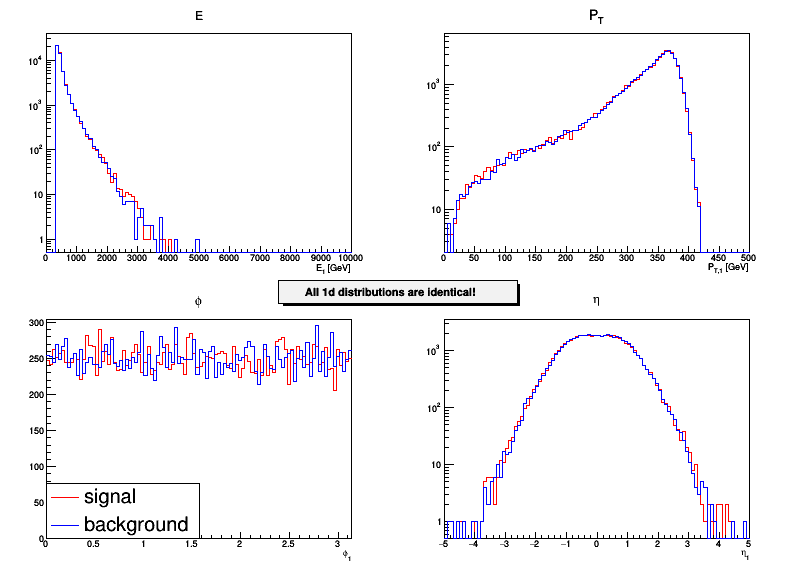

In [6]:
if 'c1' in locals(): # check if histograms are defined on cell rerun
    hE1_s.Reset()
    hPt1_s.Reset()
    hEta1_s.Reset()
    hPhi1_s.Reset()

    hE1_b.Reset()
    hPt1_b.Reset()
    hEta1_b.Reset()
    hPhi1_b.Reset()
    
    c1.Clear()

# Weights    
#wb=weights=toy_b['weight']
#ws=weights=toy_s['weight']


fill_hist(hE1_s,toy_s['E1'])
hE1_s.SetLineColor(kRed)

fill_hist(hPt1_s,toy_s['Pt1'])
hPt1_s.SetLineColor(kRed)

fill_hist(hEta1_s,toy_s['Eta1'])
hEta1_s.SetLineColor(kRed)

fill_hist(hPhi1_s,toy_s['Phi1'])
hPhi1_s.SetLineColor(kRed)

fill_hist(hE1_b,toy_b['E1'])
hE1_b.SetLineColor(kBlue)

fill_hist(hPt1_b,toy_b['Pt1'])
hPt1_b.SetLineColor(kBlue)

fill_hist(hEta1_b,toy_b['Eta1'])
hEta1_b.SetLineColor(kBlue)

fill_hist(hPhi1_b,toy_b['Phi1'])
hPhi1_b.SetLineColor(kBlue)

gStyle.SetOptStat(0)
c1.Divide(2,2)

pad1=c1.cd(1)
pad1.SetLogy()
hE1_s.SetXTitle('E_{1} [GeV]')
hE1_s.Draw()
hE1_b.Draw('same')

pad2=c1.cd(2)
pad2.SetLogy()
hPt1_s.Draw()
hPt1_s.SetXTitle('P_{T,1} [GeV]')
hPt1_b.Draw('same')

pad3=c1.cd(3)
hPhi1_s.SetMinimum(0)
hPhi1_s.SetXTitle('#phi_{1}')
hPhi1_s.Draw()
hPhi1_b.Draw('same')

leg = TLegend(0.1,0.1,.5,0.3)
leg.AddEntry(hPhi1_s,'signal','l')
leg.AddEntry(hPhi1_b,'background','l')
leg.Draw()

pad4=c1.cd(4)
pad4.SetLogy()
hEta1_s.SetXTitle('#eta_{1}')
hEta1_s.Draw()
hEta1_b.Draw('same')

c1.cd(0)
comment = TPaveLabel(.35,.47,.65,.51,'All 1d distributions are identical!');
comment.Draw();

c1.Draw()
c1.SaveAs('toy_1d.png')

### Correlated quantities looks different between signal and background

In [7]:
# some othe histograms
nbins=100
nb2  = 50

hM_s      = TH1F('hM_s','',nbins,0,1500)
hdphi_s   = TH1F('hdphi_s','',nbins,0,3.14)
hE1E2_s   = TH2F('hE1E2_s','',nb2,0,5000,nb2,0,5000)
hPt1Pt2_s = TH2F('hPt1Pt2_s','',nb2,0,500,nb2,0,500)

hM_b      = TH1F('hM_b','',nbins,0,1500)
hdphi_b   = TH1F('hdphi_b','',nbins,0,3.14)
hE1E2_b   = TH2F('hE1E2_b','',nb2,0,5000,nb2,0,5000)
hPt1Pt2_b = TH2F('hPt1Pt2_b','',nb2,0,500,nb2,0,500)

c2=TCanvas('c2','',800,600)

Warning in <TROOT::Append>: Replacing existing TH1: hdphi_b (Potential memory leak).


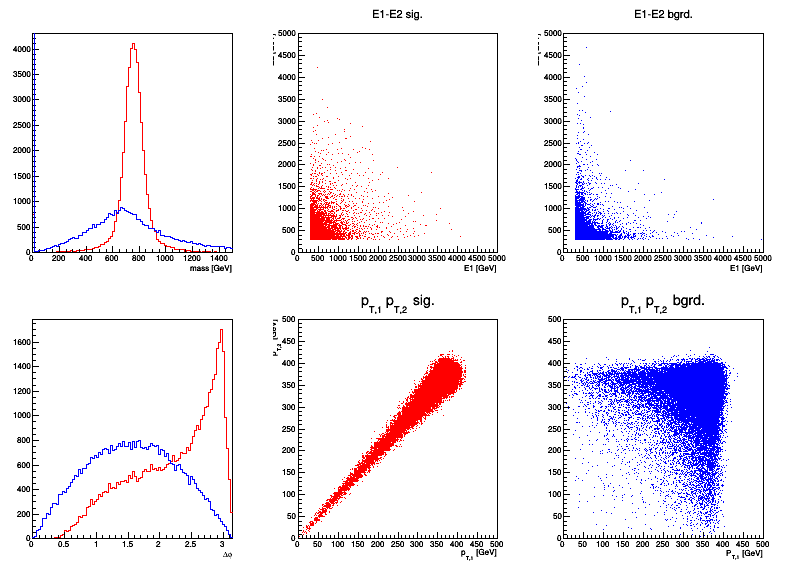

In [8]:
if 'c2' in locals(): # check if histograms are defined on cell rerun
    hM_s.Reset()
    hdphi_s.Reset()
    hE1E2_s.Reset()
    hPt1Pt2_s.Reset()

    hM_b.Reset()
    hdphi_b.Reset()
    hE1E2_b.Reset()
    hPt1Pt2_b.Reset()

    c2.Clear()


fill_hist(hM_s,toy_s['mass'])
hM_s.SetLineColor(kRed)

fill_hist(hdphi_s,toy_s['dphi'])
hdphi_s.SetLineColor(kRed)

fill_hist(hE1E2_s, np.stack((toy_s['E1'],toy_s['E2']),axis=1))
hE1E2_s.SetMarkerColor(kRed)

fill_hist(hPt1Pt2_s, np.stack((toy_s['Pt1'],toy_s['Pt2']),axis=1))
hPt1Pt2_s.SetMarkerColor(kRed)

fill_hist(hM_b,toy_b['mass'])
hM_b.SetLineColor(kBlue)

fill_hist(hdphi_b,toy_b['dphi'])
hdphi_b.SetLineColor(kBlue)

fill_hist(hE1E2_b, np.stack((toy_b['E1'],toy_b['E2']),axis=1))
hE1E2_b.SetMarkerColor(kBlue)

fill_hist(hPt1Pt2_b, np.stack((toy_b['Pt1'],toy_b['Pt2']),axis=1))
hPt1Pt2_b.SetMarkerColor(kBlue)

gStyle.SetOptStat(0)
c2.Divide(3,2)

pad1=c2.cd(1)
hM_s.SetXTitle('mass [GeV]')
hM_s.Draw()
hM_b.Draw('same')

pad4=c2.cd(4)
hdphi_s.SetXTitle('#Delta#phi')
hdphi_s.Draw()
hdphi_b.Draw('same')

pad2=c2.cd(2)
hE1E2_s.SetXTitle('E1 [GeV]')
hE1E2_s.SetYTitle('E2 [GeV]')
hE1E2_s.SetTitle('E1-E2 sig.')
hE1E2_s.Draw()

pad3=c2.cd(3)
hE1E2_b.SetXTitle('E1 [GeV]')
hE1E2_b.SetYTitle('E2 [GeV]')
hE1E2_b.SetTitle('E1-E2 bgrd.')
hE1E2_b.Draw()

pad5=c2.cd(5)
hPt1Pt2_s.SetXTitle('p_{T,1} [GeV]')
hPt1Pt2_s.SetYTitle('p_{T,2} [GeV]')
hPt1Pt2_s.SetTitle('p_{T,1} p_{T,2} sig.')
hPt1Pt2_s.Draw()

pad6=c2.cd(6)
hPt1Pt2_b.SetXTitle('P_{T,1} [GeV]')
hPt1Pt2_b.SetXTitle('P_{T,1} [GeV]')
hPt1Pt2_b.SetTitle('p_{T,1} p_{T,2} bgrd.')
hPt1Pt2_b.Draw()

c2.Draw()

### While the 1dimensional distribution are identical there are clearly different (linear and non-linear) correlations in these signal and background toy events the Neural Network can fins out about.